<a href="https://colab.research.google.com/github/napoles-uach/Ai4sci/blob/main/PiezoElectric_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --pre deepchem

In [ ]:
!pip3 install dgl-cu100

In [ ]:
pip install pymatgen

In [1]:
import deepchem as dc

In [2]:
import os
os.environ['DEEPCHEM_DATA_DIR'] = os.getcwd()

In [3]:
from pymatgen.ext.matproj import MPRester

In [4]:
#mpr = MPRester("GVKAlZWLJyoftCu7f")
#data2 = mpr.query({'elasticity': {'$exists': True}}, ['material_id', 'elasticity'])
mpr = MPRester("GVKAlZWLJyoftCu7f")
data2 = mpr.query({'piezo': {'$exists': True}}, ['material_id', 'piezo'])

100%|██████████| 3399/3399 [00:01<00:00, 1728.72it/s]


In [5]:
m1=data2[0]['piezo']['piezoelectric_tensor']

In [6]:
def mat2vec(mat):
  vec = []
  for row in mat:
    vec = vec + row
  return vec

In [7]:
import numpy as np

In [24]:
stiff_list = []
struc_list = []
for mat in data2[:1000]:
  stiffness = mat['piezo']['piezoelectric_tensor']
  #id = [mat['material_id']]
  stiff_list.append(mat2vec(stiffness))
  id=mat['material_id']
  structure = mpr.get_structure_by_material_id(id)
  struc_list.append(structure)

In [25]:
X = struc_list
y = stiff_list
#dataset = dc.data.NumpyDataset(X, y)

In [75]:
featurizer = dc.feat.CGCNNFeaturizer()
ecfp = featurizer.featurize(struc_list)
ecfp.shape
#(5, 1024)
dataset = dc.data.NumpyDataset(X=ecfp, y=np.array(stiff_list))
len(dataset)

1000

In [76]:
dataset

<NumpyDataset X.shape: (1000,), y.shape: (1000, 18), w.shape: (1000, 1), task_names: [ 0  1  2 ... 15 16 17]>

In [77]:
splitter = dc.splits.RandomSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset=dataset, frac_train=0.6, frac_valid=0.2, frac_test=0.2)

In [85]:
model = dc.models.CGCNNModel(mode='regression', batch_size=32, learning_rate=0.001,n_tasks=18)
#model.fit(train_dataset)
model.fit(train_dataset, nb_epoch=50,)
#model.fit()

0.5346453857421875

In [86]:
dc.metrics.mean_absolute_error

<function sklearn.metrics._regression.mean_absolute_error>

In [87]:
metric = dc.metrics.Metric(dc.metrics.mean_absolute_error)#(dc.metrics.mean_squared_error)
print("Training set score:", model.evaluate(train_dataset, [metric]))

Training set score: {'mean_absolute_error': 0.2640553247794142}


In [81]:
out=model.predict(valid_dataset)

In [88]:
out[3]

array([-0.25247476, -0.48004305,  0.0795521 ,  0.49180374,  0.1786225 ,
       -1.116992  , -0.70188075,  0.6650546 , -0.5097517 , -0.32084715,
        0.4344903 ,  0.23232909,  0.00202659, -0.2483889 , -0.4283599 ,
        0.01086485,  0.15594947, -0.6998137 ], dtype=float32)

In [89]:
tru=valid_dataset

In [90]:
tru.y[3]

array([ 0.     ,  0.     ,  0.     ,  0.     , -0.09173,  0.     ,
        0.     ,  0.     ,  0.     ,  1.48617,  0.     ,  0.     ,
       -0.00455,  0.41373,  0.2939 ,  0.     ,  0.     ,  0.     ])

In [91]:
import matplotlib.pyplot as plt


In [92]:
import seaborn as sns

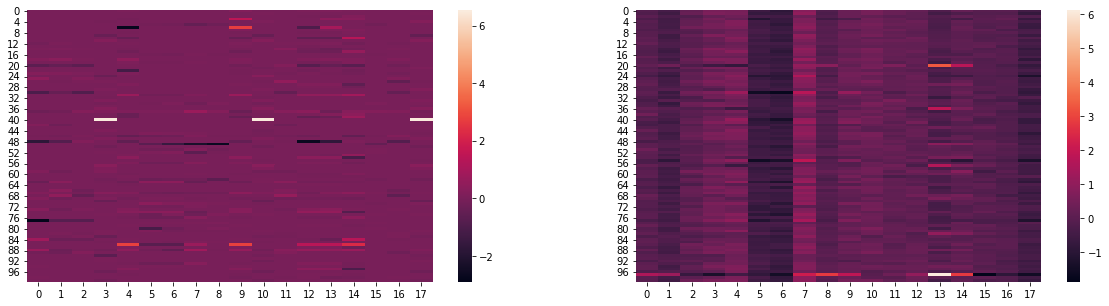

In [95]:
fig, axs = plt.subplots(ncols=2,figsize=(20,5))
sns.heatmap(tru.y[:100],ax=axs[0])
sns.heatmap(out[:100],ax=axs[1])